<a href="https://colab.research.google.com/github/AR615598/Classifying_Cancer_Cells/blob/christine/cancer_cell_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [151]:
# Author: Alexander Ramirez, Christine Wang

# General Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# ML Libraries
import torch 
import keras
import sklearn
import tensorflow

In [152]:
# Loading CSV
csv = 'https://raw.githubusercontent.com/AR615598/Classifying_Cancer_Cells/main/Cancer_Data.csv'
# save as Pandas dataframe
cc = pd.read_csv(csv)

To Do 


1.   Data Exploration, linearity etc 
3.   Clean the data
4.   Preprocess the data, like normalizing, standardize 



<h2> Identifying and Distinguishing Between Benign and Malignant Cells </h2>
It is a common misconception that everyone has cancerous cells in their body, the reality is that our bodies are constantly producing cells that have the potential to become cancerous. Cancerous cells exhibit different behavior than normal cells, as they do not adhere to the same protocols and persistently reproduce without undergoing routine cell death. This unchecked growth leads to the development of cancerous tumors, and the spread of cancerous cells through the body. It is noteworthy that the body does not always recognize cancerous cells as foreign, and in fact, sometimes is self-sabatoges itself by supporting their growth by providing means of acheing growth throught things liek blood lines. Consequently, tumors represent the manifestation of cancer.

While it's natural to feel frightened about cancer, it's important to understand the differences between benign and malignant cells. Although benign cells are noncancerous, they can still exhibit abnormal cell growth and form tumors. The crucial difference is that benign cells cannot invade other tissues, which means they are typically not life-threatening. However, they should still be monitored because they can displace other organs. For example, a brain tumor can put pressure on sensitive areas of the brain.

On the other hand, malignant cells are typically more life-threatening because they can invade other tissues. This allows them to spread to other organs and potentially cause organ failure. The systems that allow cells to function normally are very specialized, and the invasion of malignant cells disrupts this delicate balance and causes damage. As a result, it's crucial to identify malignant cells as early as possible and take appropriate steps to prevent their spread.

Another crucial factor to consider when distinguishing between benign and malignant cells is the difference in treatment options. Benign tumors are typically treated through surgical removal, and once removed, they are unlikely to regrow as long as all the abnormal cells have been removed.

In contrast, malignant tumors can spread to other parts of the body and require more aggressive treatments, such as chemotherapy, radiation therapy, or targeted therapy, to eradicate cancerous cells throughout the body. In some cases, surgery may also be necessary to remove the primary tumor, as well as any other tumors that have developed as a result of the cancer spreading. Because of the potential for malignant cells to spread, it's important to diagnose and treat them as early as possible to increase the chances of successful treatment.
This is wny identifying cancerous cells and classifying them is so important, being able to identify benign cells allows doctors to plan accordingly with alot of information, malignant cells on the other hand are much more difficult to treat and makes treatment more difficult, but being able to identify them early will lead to drastically better outcomes. 

<h2>About the Dataset</h2>

The dataset is a comprehensive collection of information about cancer cells, providing nearly 600 examples for analysis. Each example in the dataset is characterized by 32 columns, with 30 of them being used to describe the visual characteristics of the cell. These visual characteristics provide important information about the cancer cell, including its radius, texture, perimeter, area, smoothness, compactness, concavity, and concave points.

The last two columns in the dataset are the example ID and the label. The example ID is a unique identifier for each example, which can be used to keep track of specific instances within the dataset. The label column indicates whether the cell is classified as malignant or benign.



In [153]:
cc

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,...,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,...,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,...,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,...,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,...,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,926424,M,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,...,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,926682,M,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,...,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,926954,M,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,...,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
567,927241,M,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,...,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400


In [154]:
cc = pd.get_dummies(cc, columns=['diagnosis'])
cc = cc.rename(columns={'diagnosis_B': 'Benign', 'diagnosis_M': 'Malignant'})
cc

,id,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Benign,Malignant
0,842302,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,...,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890,0,1
1,842517,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,...,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902,0,1
2,84300903,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,...,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758,0,1
3,84348301,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,...,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300,0,1
4,84358402,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,...,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,926424,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,...,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115,0,1
565,926682,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,...,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637,0,1
566,926954,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,...,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820,0,1
567,927241,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,...,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400,0,1


In [155]:
cc['Benign'].value_counts()

1    357
0    212
Name: Benign, dtype: int64

# Data Exploration

We need to explore the data to get an idea of the certain features that determines whether a tumor is benign or malignant. This part examines different features of tumors that were identified as benign. First we divide all the tumors that were benign and malignant into their own datasets.

In [167]:
b_group = cc.loc[cc['Benign'] == 1]
m_group = cc.loc[cc['Malignant'] == 1]

In [169]:
b_group.describe()

,id,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Benign,Malignant
count,3.570000e+02,357.000000,357.000000,357.000000,357.000000,357.000000,357.000000,357.000000,357.000000,357.000000,...,357.000000,357.000000,357.000000,357.000000,357.000000,357.000000,357.000000,357.000000,357.0,357.0
mean,2.654382e+07,12.146524,17.914762,78.075406,462.790196,0.092478,0.080085,0.046058,0.025717,0.174186,...,87.005938,558.899440,0.124959,0.182673,0.166238,0.074444,0.270246,0.079442,1.0,0.0
std,1.167397e+08,1.780512,3.995125,11.807438,134.287118,0.013446,0.033750,0.043442,0.015909,0.024807,...,13.527091,163.601424,0.020013,0.092180,0.140368,0.035797,0.041745,0.013804,0.0,0.0
min,8.913000e+03,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,...,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156600,0.055210,1.0,0.0
25%,8.746620e+05,11.080000,15.150000,70.870000,378.200000,0.083060,0.055620,0.020310,0.015020,0.158000,...,78.270000,447.100000,0.110400,0.112000,0.077080,0.051040,0.240600,0.070090,1.0,0.0
50%,9.089160e+05,12.200000,17.390000,78.180000,458.400000,0.090760,0.075290,0.037090,0.023440,0.171400,...,86.920000,547.400000,0.125400,0.169800,0.141200,0.074310,0.268700,0.077120,1.0,0.0
75%,8.812816e+06,13.370000,19.760000,86.100000,551.100000,0.100700,0.097550,0.059990,0.032510,0.189000,...,96.590000,670.000000,0.137600,0.230200,0.221600,0.097490,0.298300,0.085410,1.0,0.0
max,9.113205e+08,17.850000,33.810000,114.600000,992.100000,0.163400,0.223900,0.410800,0.085340,0.274300,...,127.100000,1210.000000,0.200600,0.584900,1.252000,0.175000,0.422800,0.148600,1.0,0.0


In [170]:
m_group.describe()

,id,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Benign,Malignant
count,2.120000e+02,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000,...,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000,212.0,212.0
mean,3.681805e+07,17.462830,21.604906,115.365377,978.376415,0.102898,0.145188,0.160775,0.087990,0.192909,...,141.370330,1422.286321,0.144845,0.374824,0.450606,0.182237,0.323468,0.091530,0.0,1.0
std,1.378965e+08,3.203971,3.779470,21.854653,367.937978,0.012608,0.053987,0.075019,0.034374,0.027638,...,29.457055,597.967743,0.021870,0.170372,0.181507,0.046308,0.074685,0.021553,0.0,0.0
min,8.670000e+03,10.950000,10.380000,71.900000,361.600000,0.073710,0.046050,0.023980,0.020310,0.130800,...,85.100000,508.100000,0.088220,0.051310,0.023980,0.028990,0.156500,0.055040,0.0,1.0
25%,8.613450e+05,15.075000,19.327500,98.745000,705.300000,0.094010,0.109600,0.109525,0.064620,0.174050,...,119.325000,970.300000,0.130475,0.244475,0.326425,0.152750,0.276500,0.076302,0.0,1.0
50%,8.953665e+05,17.325000,21.460000,114.200000,932.000000,0.102200,0.132350,0.151350,0.086280,0.189900,...,138.000000,1303.000000,0.143450,0.356350,0.404900,0.182000,0.310300,0.087600,0.0,1.0
75%,8.911290e+06,19.590000,23.765000,129.925000,1203.750000,0.110925,0.172400,0.203050,0.103175,0.209850,...,159.800000,1712.750000,0.155975,0.447850,0.556175,0.210675,0.359225,0.102625,0.0,1.0
max,9.112962e+08,28.110000,39.280000,188.500000,2501.000000,0.144700,0.345400,0.426800,0.201200,0.304000,...,251.200000,4254.000000,0.222600,1.058000,1.170000,0.291000,0.663800,0.207500,0.0,1.0


Benign tumors cells are known to be smooth compared to malignant tumors cells, we can examine features in relation to the smoothness of the cells.

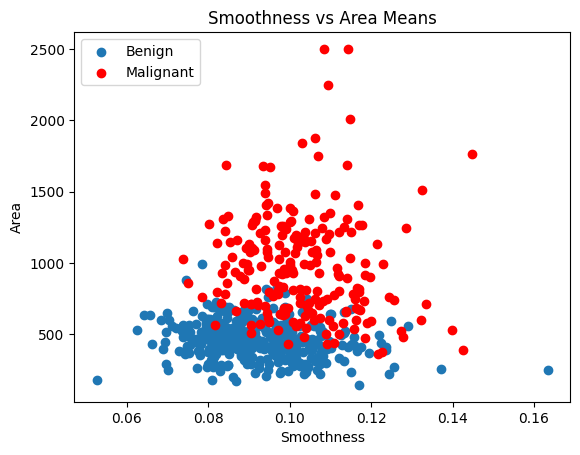

In [173]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.scatter(b_group['smoothness_mean'], b_group['area_mean'], label="Benign")
ax.scatter(m_group['smoothness_mean'], m_group['area_mean'], color = 'r', label="Malignant")

plt.title('Smoothness vs Area Means')
plt.xlabel('Smoothness')
plt.ylabel('Area')
plt.legend(loc="upper left")
plt.show()

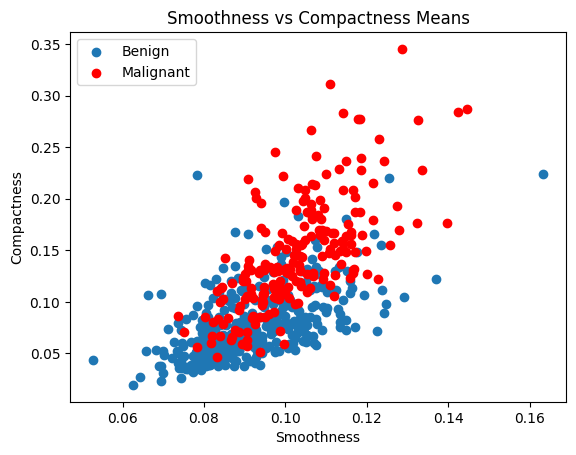

In [172]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.scatter(b_group['smoothness_mean'], b_group['compactness_mean'], label="Benign")
ax.scatter(m_group['smoothness_mean'], m_group['compactness_mean'], color = 'r', label="Malignant")

plt.title('Smoothness vs Compactness Means')
plt.xlabel('Smoothness')
plt.ylabel('Compactness')
plt.legend(loc="upper left")
plt.show()

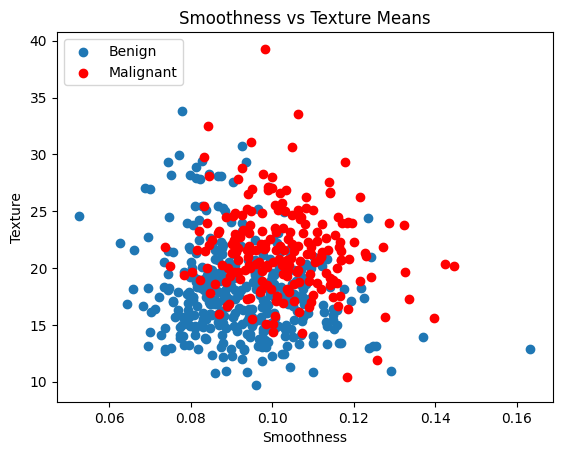

In [161]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.scatter(b_group['smoothness_mean'], b_group['texture_mean'], label="Benign")
ax.scatter(m_group['smoothness_mean'], m_group['texture_mean'], color = 'r', label="Malignant")

plt.title('Smoothness vs Texture Means')
plt.xlabel('Smoothness')
plt.ylabel('Texture')
plt.legend(loc="upper left")
plt.show()

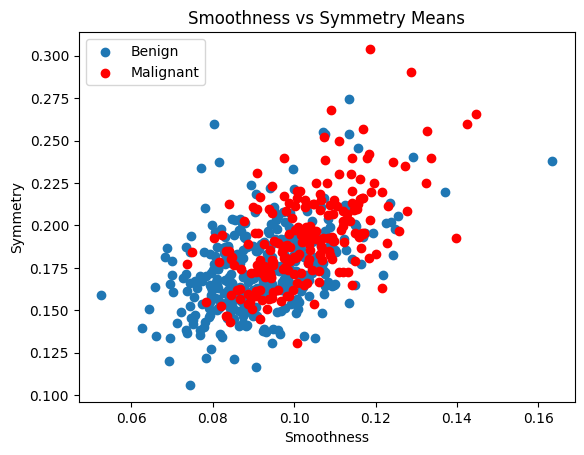

In [162]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.scatter(b_group['smoothness_mean'], b_group['symmetry_mean'], label="Benign")
ax.scatter(m_group['smoothness_mean'], m_group['symmetry_mean'], color = 'r', label="Malignant")

plt.title('Smoothness vs Symmetry Means')
plt.xlabel('Smoothness')
plt.ylabel('Symmetry')
plt.legend(loc="upper left")
plt.show()

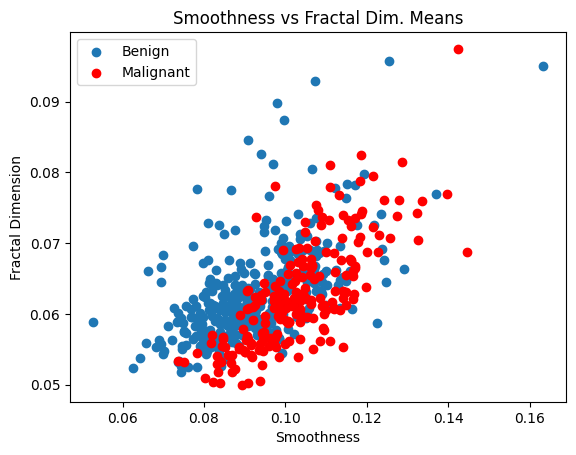

In [163]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.scatter(b_group['smoothness_mean'], b_group['fractal_dimension_mean'], label="Benign")
ax.scatter(m_group['smoothness_mean'], m_group['fractal_dimension_mean'], color = 'r', label="Malignant")

plt.title('Smoothness vs Fractal Dim. Means')
plt.xlabel('Smoothness')
plt.ylabel('Fractal Dimension')
plt.legend(loc="upper left")
plt.show()

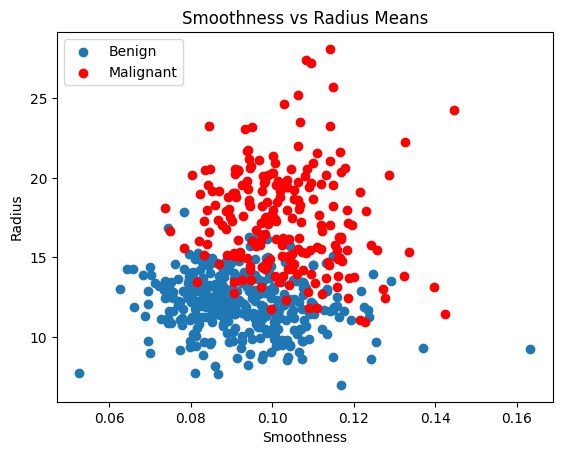

In [164]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.scatter(b_group['smoothness_mean'], b_group['radius_mean'], label="Benign")
ax.scatter(m_group['smoothness_mean'], m_group['radius_mean'], color = 'r', label="Malignant")

plt.title('Smoothness vs Radius Means')
plt.xlabel('Smoothness')
plt.ylabel('Radius')
plt.legend(loc="upper left")
plt.show()

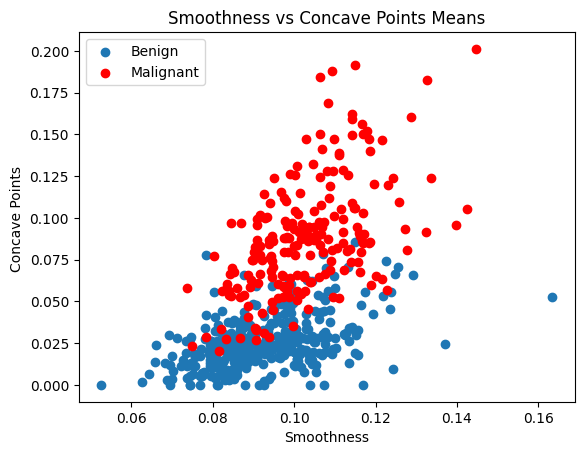

In [165]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.scatter(b_group['smoothness_mean'], b_group['concave points_mean'], label="Benign")
ax.scatter(m_group['smoothness_mean'], m_group['concave points_mean'], color = 'r', label="Malignant")

plt.title('Smoothness vs Concave Points Means')
plt.xlabel('Smoothness')
plt.ylabel('Concave Points')
plt.legend(loc="upper left")
plt.show()

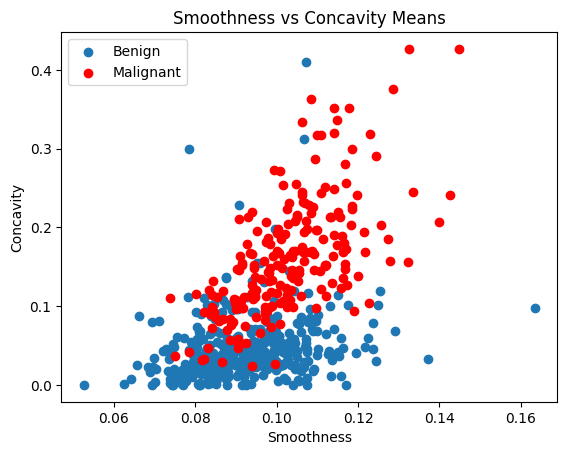

In [166]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.scatter(b_group['smoothness_mean'], b_group['concavity_mean'], label="Benign")
ax.scatter(m_group['smoothness_mean'], m_group['concavity_mean'], color = 'r', label="Malignant")

plt.title('Smoothness vs Concavity Means')
plt.xlabel('Smoothness')
plt.ylabel('Concavity')
plt.legend(loc="upper left")
plt.show()

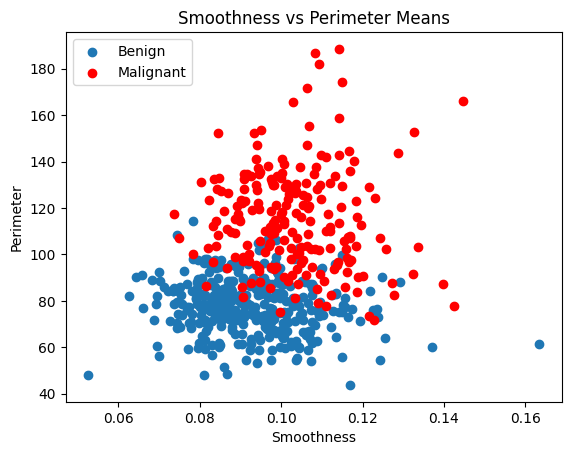

In [175]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.scatter(b_group['smoothness_mean'], b_group['perimeter_mean'], label="Benign")
ax.scatter(m_group['smoothness_mean'], m_group['perimeter_mean'], color = 'r', label="Malignant")

plt.title('Smoothness vs Perimeter Means')
plt.xlabel('Smoothness')
plt.ylabel('Perimeter')
plt.legend(loc="upper left")
plt.show()

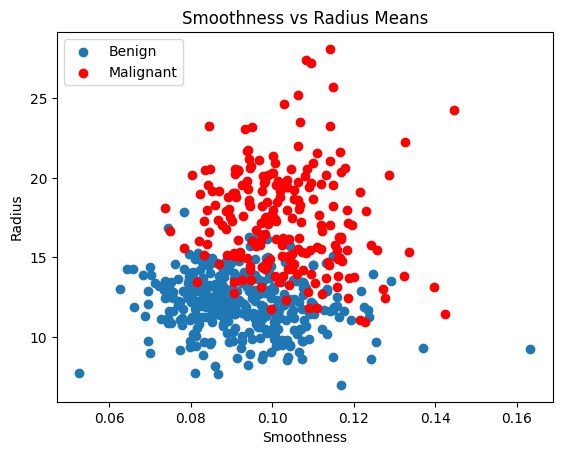

In [176]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.scatter(b_group['smoothness_mean'], b_group['radius_mean'], label="Benign")
ax.scatter(m_group['smoothness_mean'], m_group['radius_mean'], color = 'r', label="Malignant")

plt.title('Smoothness vs Radius Means')
plt.xlabel('Smoothness')
plt.ylabel('Radius')
plt.legend(loc="upper left")
plt.show()

# Observations

Based on the scatter plots, malignant and benign cells labels are correlated to cell size. Features such as concavity, area, radius, concave points, perimeter with cell smoothness taken into account influences the classification of a tumor cell. 


To-Do: Machine Learning
Choose 3+

1.   Make a Decision tree, DT, RF, BRF, XGBoost
2.   Clustering: K-nearest neighbors, DBSCAN
3.   Nerual Networks: Perceptron, CNN, NN
4.   SVM (Support Vector Machine)
5.   Probabalisitc Models: Naive bayes 

